In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from RMBG.train import train
from Preprocess.util import plot_Data

In [2]:
image_h = 16   # Height of the images
image_w = 16   # Width of the images
Data_path = r"D:/git ex/DA/1/RMBG-U2NET/Data/"
model_path = r"D:/git ex/DA/1/RMBG-U2NET/Data/file/model.h5"
test_path = r"D:/git ex/DA/1/RMBG-U2NET/Data/test/images/*"

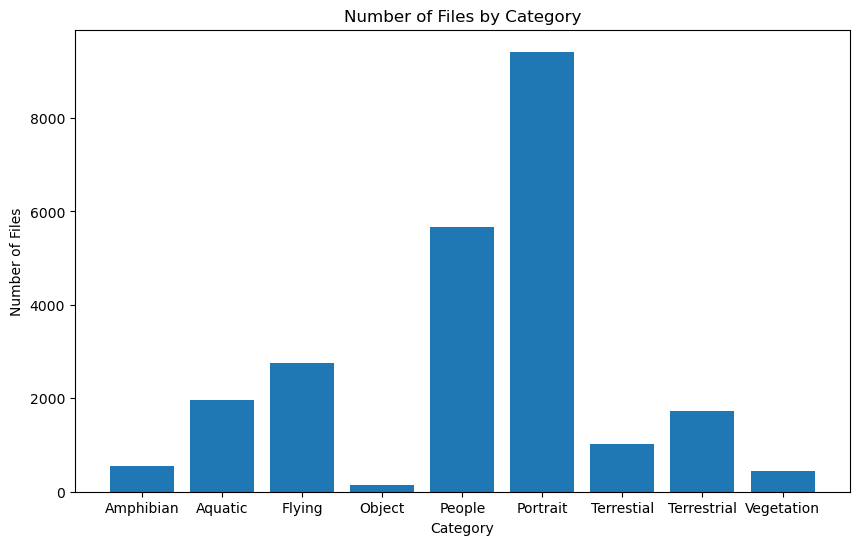

In [3]:
# Full dataset information
plot_Data(r"D:/git ex/DA/1/RMBG-U2NET/Data/images")

In [3]:
# skip running this cell if you want to use a pre-trained model
# initilizing training process
T = train(
    IMG_H = image_h,
    IMG_W = image_w,
    BATCH = 2,
    LR = 0.01,
    EPOCH = 10,
    SPLIT= 0.4,
    PATH = Data_path)
# training the model 
T.train_model()

D:/git ex/DA/1/RMBG-U2NET/Data/\file
Train: 600/600 - Valid:400/400

Model: "U-2-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 22, 22, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 8, 8, 64)             9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 8, 8, 64)             256       ['conv1_conv[0][0]']          
 on)                   

d:\ProgramFiles\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 1432s 5s/step - loss: 0.6146 - val_loss: 0.5527 - lr: 0.0100
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 0.5606
Epoch 2: val_loss did not improve from 0.55273
300/300 [==============================] - 1415s 5s/step - loss: 0.5606 - val_loss: 0.8812 - lr: 0.0100
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 0.5531
Epoch 3: val_loss did not improve from 0.55273
300/300 [==============================] - 1412s 5s/step - loss: 0.5531 - val_loss: 0.5888 - lr: 0.0100
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 0.5493
Epoch 4: val_loss did not improve from 0.55273
300/300 [==============================] - 1415s 5s/step - loss: 0.5493 - val_loss: 0.6696 - lr: 0.0100
Epoch 5/10
300/300 [==============================] - ETA: 0s - loss: 0.5463
Epoch 5: val_loss did not improve from 0.55273
300/300 [==============================] - 1413s 5s/step - loss: 0.5463 - val_loss: 0.59

  0%|          | 0/4 [00:00<?, ?it/s]

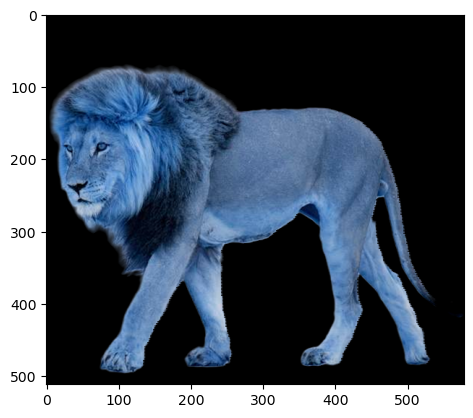

 25%|██▌       | 1/4 [00:01<00:03,  1.04s/it]

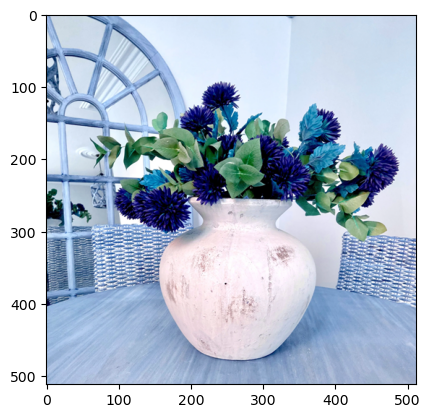

 50%|█████     | 2/4 [00:01<00:01,  1.85it/s]

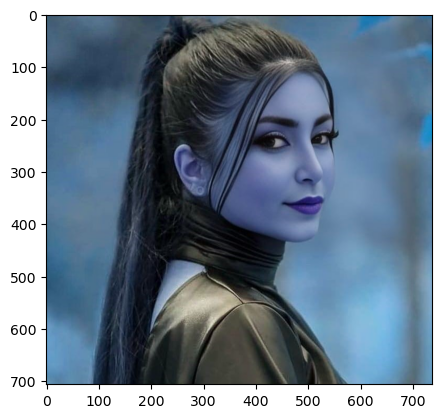

 75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

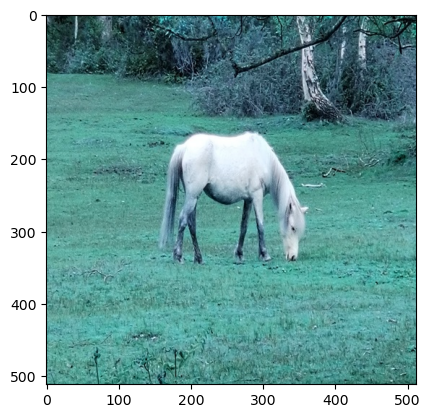

100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


In [4]:

# Set environment variable to suppress TensorFlow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# Seeding for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directory for storing output masks
file = Data_path + "/test/masks"
if not os.path.exists(file):
    os.makedirs(file)

# Load the trained model
model = tf.keras.models.load_model(model_path)

data_x = glob(test_path)
for path in tqdm(data_x, total=len(data_x)):
    print
    # Extract the file name
    # name = path.split("/")[-1].split(".")[0]
    name = (path[41:].split(".")[0])
    # Read the image using OpenCV
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(image)
    plt.show()
    # Get the height and width of the original image
    h, w, _ = image.shape

    # Resize the image to the specified dimensions
    x = cv2.resize(image, (image_w, image_h))

    # Normalize the image by dividing by 255.0
    x = x/255.0

    # Convert the image to a float32 data type
    x = x.astype(np.float32)  # (h, w, 3)

    # Expand the image to a 4D tensor with a batch size of 1
    x = np.expand_dims(x, axis=0)  # (1, h, w, 3)

    # Make a prediction using the model
    y = model.predict(x, verbose=0)[0][:, :, -1]
    # Resize the prediction to the original image dimensions
    y = cv2.resize(y, (w, h))
    # Expand the prediction to a 3D tensor
    y = np.expand_dims(y, axis=-1)

    """
    Create a masked image by multiplying
    the original image with the prediction
    """
    masked_image = image * y

    # Create a line for visualization purposes
    line = np.ones((h, 10, 3)) * 128

    """
    Concatenate the original image,
    line, and masked image along the width axis
    """
    cat_images = np.concatenate([image, line, masked_image], axis=1)

    # Save the concatenated image to a file
    cv2.imwrite(f"{Data_path}/test/result/{name}.png", cat_images)